In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

<h1> The Ramsey model </h1>

Want to maximize the following objective

\begin{align}
    \max\ U =& \int_{t=0}^{\infty} e^{-\rho t} u(C(t)) \frac{L(t)}{H} dt \\
    =& \frac{L(0)}{H} \int_{t=0}^{\infty} e^{-(\rho - n) t} u(C(t)) dt
\end{align}

subject to the following inter-temporal budget constraint


The first-order condition...
\begin{align}
    B e^{-(\rho - n)t}u'(C(t)) =& \lambda e^{-R(t)}e^{nt} \\
    \ln B -(\rho - n)t + \ln u'(C(t)) =& \ln \lambda -R(t) + nt \\
    -(\rho - n) + \frac{u''(C(t))C(t)}{u'(C(t))}\frac{\dot{C}(t)}{C(t)} =& -r(t) + n \\
    - \frac{u''(C(t))C(t)}{u'(C(t))}\frac{\dot{C}(t)}{C(t)} =& r(t) - \rho \\
    - \frac{u''(C(t))C(t)}{u'(C(t))}\frac{\dot{C}(t)}{C(t)} =& r(t) - \rho \\
\end{align}

Use the following substitutions in order to change to per unit effective labor units...
\begin{align}
    A(t)c(t) = C(t) \\  
    A(0)e^{gt}c(t) = C(t) \\
    A(t)\dot{c}(t) + \dot{A}(t)c(t) = \dot{C}(t) \\
\end{align}
...making the relevant substitutions yields...
\begin{align}
    %- \frac{u''(A(t)c(t))A(t)c(t)}{u'(A(t)c(t))}\frac{A(t)\dot{c}(t) + \dot{A}(t)c(t)}{A(t)c(t)} =& r(t) - \rho \\
    %- \frac{u''(A(t)c(t))A(t)c(t)}{u'(A(t)c(t))}\bigg(\frac{\dot{c}(t)}{c(t)} + \frac{\dot{A}(t)}{A(t)}\bigg) =& r(t) - \rho \\
    - \frac{u''(A(0)e^{gt}c(t))A(0)e^{gt}c(t)}{u'(A(0)e^{gt}c(t))}\bigg(\frac{\dot{c}(t)}{c(t)} + g\bigg) =& r(t) - \rho \\
\end{align}

Assuming that $u$ is homogenous of degree $k$, then the above simplifies to 
\begin{align}
    - \frac{u''(c(t))c(t)}{u'(c(t))}\bigg(\frac{\dot{c}(t)}{c(t)} + g\bigg) =& r(t) - \rho \\
    \frac{\dot{c}(t)}{c(t)} =& \frac{1}{\epsilon(t)}(r(t) - \rho) - g \\
\end{align}
where 

$$ \epsilon(t) = -\frac{u''(c(t))c(t)}{u'(c(t))} $$

is the elasticity of marginal utility from consumption.

In [11]:
# define some variables
t, k, c = sym.symbols('t, k, c')

# define some parameters
alpha, sigma = sym.symbols('alpha, sigma')
rho, theta = sym.symbols('rho, theta')
g, n, delta = sym.symbols('g, n, delta')

# define functional form for intensive output
gamma = (sigma - 1) / sigma
f = (alpha * k**gamma + (1 - alpha))**(1 / gamma)

# define functional form for utility
u = c**(1 - theta) / (1 - theta)

# equation of motion for capital (per unit effective labor)
k_dot = f - c - (g + n + delta) * k

# equation of motion for consumption (per unit effective labor)
mpk = sym.diff(f, k, 1)
epsilon_mu = -(sym.diff(u, c, 2) * c) / sym.diff(u, c)
c_dot = ((1 / epsilon_mu) * (mpk - delta - rho) - g) * c
rhs = {'k': k_dot, 'c': c_dot}

# define some boundary conditions
k0 = 5.0
kstar = (1 - alpha)**(1 / gamma) * ((alpha / (delta + rho + theta * g))**(gamma / (gamma - 1)) - alpha)**(-1 / gamma)
cstar = f.subs({k: kstar}) - (g + n + delta) * kstar
bcs = {'lower': [k - k0], 'upper': [c - cstar]}

ramsey_params = {'g': 0.02, 'n': 0.02, 'alpha': 0.15, 'sigma': 0.5,
                 'theta': 1.05, 'rho': 0.03, 'delta': 0.04}

In [12]:
ramsey = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                    independent_var='t',
                                                    rhs=rhs,
                                                    boundary_conditions=bcs,
                                                    params=ramsey_params)

In [13]:
ramsey_solver = pycollocation.OrthogonalPolynomialSolver(ramsey)

In [16]:
# specify an initial guess
def steady_state_capital(g, n, alpha, delta, rho, theta, sigma): 
    """Steady-state level of capital (per unit effective labor)."""
    gamma = (sigma - 1) / sigma
    if gamma == 0:
        return (alpha / (delta + rho + theta * g))**(1 / (1 - alpha))
    else:
        return (1 - alpha)**(1 / gamma) * ((alpha / (delta + rho + theta * g))**(gamma / (gamma - 1)) - alpha)**(-1 / gamma)

def steady_state_consumption(g, n, alpha, delta, rho, theta, sigma):
    """Steady-state level of consumption (per unit effective labor)."""
    kstar = steady_state_capital(g, n, alpha, delta, rho, theta, sigma)
    return kstar**alpha - (g + n + delta) * kstar

domain = [0, 200]
ts = np.linspace(domain[0], domain[1], 1000)
ks = steady_state_capital(**ramsey_params) - (steady_state_capital(**ramsey_params) - k0) * np.exp(-ts)
initial_capital_poly = np.polynomial.Chebyshev.fit(ts, ks, 50, domain)

cs = np.log(initial_capital_poly(ks))  # guess that consumption is concave function of capital
initial_consumption_poly = np.polynomial.Chebyshev.fit(ts, cs, 50, domain)
initial_ramsey_coefs = {'k': initial_capital_poly.coef, 'c': initial_consumption_poly.coef}

In [17]:
ramsey_solver.solve(kind="Chebyshev",
                    coefs_dict=initial_ramsey_coefs,
                    domain=domain)


In [18]:
ramsey_solution = pycollocation.Solution(ramsey_solver)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ab49850>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10ac87d50>], dtype=object)

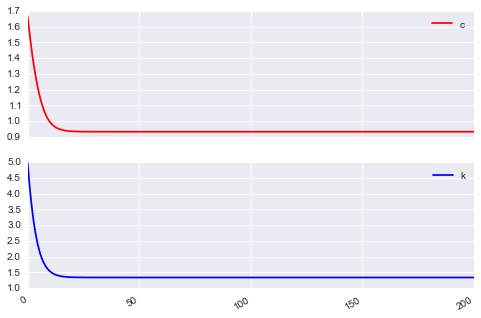

In [19]:
ramsey_solution.interpolation_knots = np.linspace(0, 200, 1000)
ramsey_solution.solution.plot(subplots=True, style=['r', 'b'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ad5d090>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10af91f50>], dtype=object)

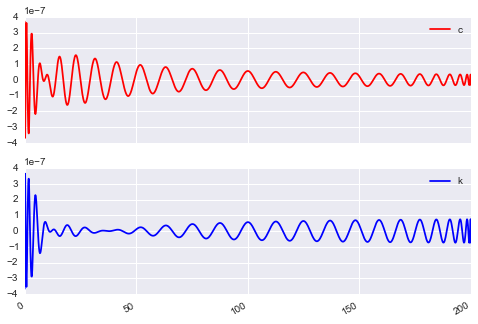

In [20]:
ramsey_solution.residuals.plot(subplots=True, style=['r', 'b'])
